In [1]:
%load_ext autoreload
%autoreload 2

# Weak Supervision VAE

Implementing some version of [Weak Supervision Variational Auto-Encoder](https://openreview.net/forum?id=0oDzoRjrbj) by Tonolini et al. 

There are some differences with the paper especially around the decoders and its still a work-in-progress as its mainly tested around the census data at the moment.

In [2]:
import os
import sys

os.chdir("..")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import torch

import flippers

# Loading benchmarks from `wrench`

`wrench` is an open source weak supervision benchmark and library created by Jieyu Zhang.

To learn more, visit https://github.com/JieyuZ2/wrench

To get the datasets, you will need to run `sh scripts/download_wrench_datasets.sh` from the root of the repository
Or grab them yourself from https://github.com/JieyuZ2/wrench#-available-datasets

In [4]:
# !cat scripts/download_wrench_datasets.sh

# !bash ./scripts/download_wrench_datasets.sh

In [5]:
from examples.utils import load_wrench_dataset, MetricsUtil

Choose your dataset here

In [6]:
datasets = ["cdr", "yelp", "youtube", "census", "spouse", "basketball", "sms", "tennis"]
dataset = "census"

data, weak_labels, polarities = load_wrench_dataset(dataset)
train, dev, test = data
L_train, L_dev, L_test = weak_labels

c:\Users\liamt\Repos\flippers\flippers\_core\_core.py:151: UserWarning: Polarity mapping if not furnished.
Make sure L captures all possible values of each weak labelers.
  warnings.warn(


In [7]:
class_balances = list(
    dev["label"].astype(int).value_counts(normalize=True).sort_index()
)
class_balances

[0.7669483905772343, 0.23305160942276568]

In [8]:
polarities

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0], dtype=int64)

In [9]:
flippers.summary(L_train, polarities)

,polarity,coverage,confidence,overlaps,matches,conflicts
0,0,0.144,1.0,0.144,0.144,0.001
1,1,0.043,1.0,0.042,0.021,0.040
2,0,0.028,1.0,0.028,0.028,0.001
3,0,0.209,1.0,0.209,0.209,0.006
4,0,0.242,1.0,0.241,0.240,0.003
...,...,...,...,...,...,...
78,0,0.150,1.0,0.145,0.145,0.061
79,0,0.002,1.0,0.001,0.000,0.001
80,1,0.038,1.0,0.038,0.020,0.038
81,0,0.695,1.0,0.687,0.660,0.201


Scoring utils:

In [10]:
y_test = test["label"].astype(int).values

In [11]:
Metrics = MetricsUtil(y_test, L_test)

# Training Label Models

## Majority Vote Model

In [12]:
from flippers.models import Voter

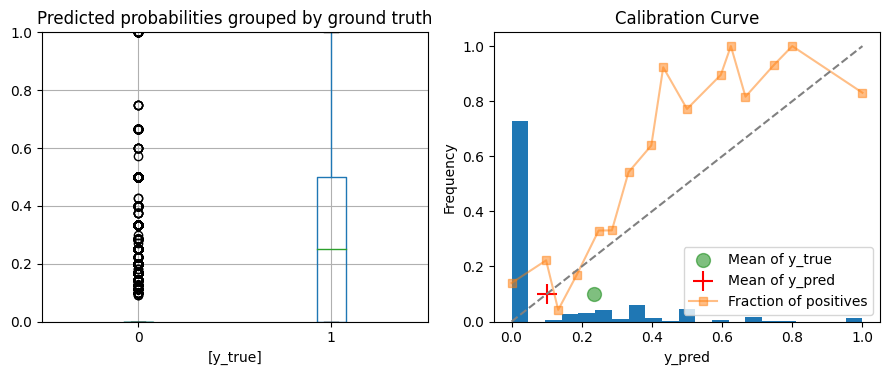

{'F1': 0.218,
 'Average_Precision': 0.522,
 'AUC': 0.724,
 'Accuracy': 0.788,
 'Balanced_Accuracy': 0.559}

In [13]:
preds_vote = Voter(polarities)
Metrics.score(preds_vote, name="MV")

## `flippers`' Snorkel Model

In [14]:
from flippers.models import SnorkelModel

In [15]:
m = SnorkelModel(polarities=polarities, class_balances=class_balances)
m.fit(L_train, learning_rate=1e-3, k=5e-3, num_epochs=10)

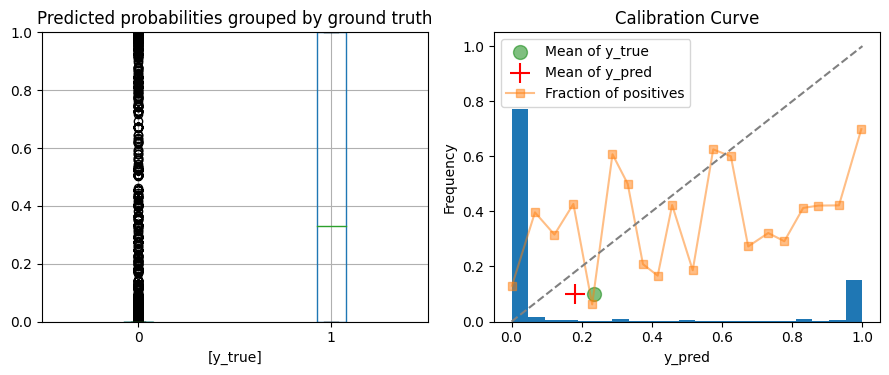

{'F1': 0.558,
 'Average_Precision': 0.652,
 'AUC': 0.839,
 'Accuracy': 0.816,
 'Balanced_Accuracy': 0.704}

In [16]:
# This is the Uniform Marginals calculation the Snorkel and Metal libraries use
# Performance should be very similar to the Snorkel model
Metrics.score(m, name="flippers")

# WS-VAE

In [17]:
device = "cuda"

In [18]:
def get_feat(df):
    df = df.copy()
    ans = pd.DataFrame([x["feature"] for x in df["data"].values.tolist()])
    return ans

In [19]:
def get_x(df):
    X = get_feat(df)
    X = torch.tensor(X.values)
    X = X.float()
    X = X.clamp(0, 1)
    X = X.to(device)
    return X

In [20]:
def get_w(L):
    Weak = torch.Tensor(L.values)
    Weak = Weak.to(device)
    return Weak

In [21]:
X_train = get_x(train)
W_train = get_w(L_train)

X_dev = get_x(dev)
W_dev = get_w(L_dev)
y_dev = dev["label"].values.astype(int)

X_test = get_x(test)
W_test = get_w(L_test)

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim


# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, n_dim, n_weak, latent_dim):
        super(VAE, self).__init__()
        self.n_dim = n_dim
        self.n_weak = n_weak
        self.latent_dim = latent_dim
        self.hidden_t = 4

        self.encoder = nn.Sequential(
            nn.Linear(self.n_dim + self.n_weak, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2 * self.latent_dim + 2),
        )

        self.decoder_x = nn.Sequential(
            nn.Linear(latent_dim + 1, 64),
            nn.ReLU(),
            nn.Linear(64, self.n_dim),
            nn.Sigmoid(),
        )

        self.decoder_t = nn.Sequential(
            nn.Linear(latent_dim + 1, self.hidden_t),
            nn.ReLU(),
            nn.Linear(self.hidden_t, self.n_weak),
            nn.LeakyReLU(),
        )

        self.polarities = nn.Parameter(torch.Tensor(polarities), requires_grad=False)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std, device=device)
        return mu + eps * std

    def forward(self, x, weak):
        data = torch.cat((x, weak), dim=1)

        mu_z, logvar_z, mu_y, logvar_y = self.encoder(data).split(
            (self.latent_dim, self.latent_dim, 1, 1), dim=1
        )
        z = self.reparameterize(mu_z, logvar_z)
        y = self.reparameterize(mu_y, logvar_y)
        latents = torch.cat((z, y), dim=1)

        x_reconstructed = self.decoder_x(latents)
        t = self.decoder_t(latents)
        weak_reconstructed = torch.sigmoid(y.sign() * (2 * self.polarities - 1) * t)

        return x_reconstructed, weak_reconstructed, mu_z, logvar_z, mu_y, logvar_y

    def predict_proba(self, x, weak):
        data = torch.cat((x, weak), dim=1)

        mu_z, logvar_z, mu_y, logvar_y = self.encoder(data).split(
            (self.latent_dim, self.latent_dim, 1, 1), dim=1
        )
        y_pred_proba = (
            1 / 2 * (1 - torch.erf(-mu_y / (np.sqrt(2) * torch.exp(0.5 * logvar_y))))
        )
        return y_pred_proba

In [23]:
import scipy

MU_Y = -scipy.special.erfinv(1 - 2 * class_balances[1]) * np.sqrt(2)
MU_Y

-0.7288339871337749

In [24]:
0.5 * (1 - scipy.special.erf(-MU_Y / (np.sqrt(2)))) - class_balances[1]

8.326672684688674e-17

In [25]:
def vae_loss(x, weak, outputs, kld_weight=1.0, gamma=1.0, gamma_2=1.0):
    x_reconstructed, weak_reconstructed, mu_z, logvar_z, mu_y, logvar_y = outputs
    loss_x = (
        nn.functional.binary_cross_entropy(x_reconstructed, x, reduction="none")
        .mean(dim=1)
        .sum()
    )
    loss_weak = (
        nn.functional.binary_cross_entropy(weak_reconstructed, weak, reduction="none")
        .mean(dim=1)
        .sum()
    )
    # loss_x = ((x- x_reconstructed)**2).mean(dim=1).sum()
    # loss_weak = ((weak - weak_reconstructed)**2).mean(dim=1).sum()
    kl_z = -0.5 * (1 + logvar_z - mu_z.pow(2) - logvar_z.exp()).mean(dim=1).sum()
    kl_y = -0.5 * (1 + logvar_y - (mu_y - MU_Y).pow(2) / 10 - logvar_y.exp()).sum()

    return loss_x + gamma * loss_weak + kld_weight * kl_z + gamma_2 * (kl_y - 5).abs()

In [26]:
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, X, Weak):
        self.X = X
        self.Weak = Weak

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Weak[idx]


from torch.utils.data import DataLoader

In [27]:
batch_size = 4096
dataset = CustomDataset(X_train, W_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate the VAE and optimizer
n_dim = X_train.shape[1]
n_weak = W_train.shape[1]
latent_dim = 8

model = VAE(n_dim, n_weak, latent_dim)
optimizer = optim.AdamW(model.parameters(), lr=5e-3, weight_decay=1e-6)
model = model.to(device)

In [28]:
# Training loop

from tqdm.notebook import trange

num_epochs = 200
epoch_range = trange(num_epochs)


for epoch in epoch_range:
    epoch_loss = 0
    for batch_X, batch_Weak in dataloader:
        batch_X = batch_X.to(device)
        batch_Weak = batch_Weak.to(device)

        outputs = model(batch_X, batch_Weak)

        loss = vae_loss(
            batch_X, batch_Weak, outputs, gamma=10, kld_weight=100, gamma_2=5
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)
    epoch_range.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
    description = {}
    description["Loss"] = f"{epoch_loss:.1f}"

    with torch.no_grad():
        x_reconstructed, weak_reconstructed, mu_z, logvar_z, mu_y, logvar_y, *_ = model(
            X_dev, W_dev
        )
        y_pred = model.predict_proba(X_dev, W_dev)
        y_pred = pd.Series(y_pred.detach().cpu().numpy()[:, 0])
        description |= {"Mu_average": (MU_Y - mu_y).mean().cpu().numpy().round(2)}
        description |= {"balance": y_pred.mean()}
        description |= {
            "Weak L2": (W_dev - weak_reconstructed).pow(2).mean().cpu().numpy().round(3)
        }
        description |= MetricsUtil(y_true=y_dev).score(
            model, y_pred=y_pred, plots=False
        )
        epoch_range.set_postfix(description)

  0%|          | 0/200 [00:00<?, ?it/s]

In [29]:
X_test = get_x(test)
W_test = get_w(L_test)

In [30]:
x_reconstructed, weak_reconstructed, mu_z, logvar_z, mu_y, logvar_y, *_ = model(
    X_test, W_test
)
y_pred = model.predict_proba(X_test, W_test)

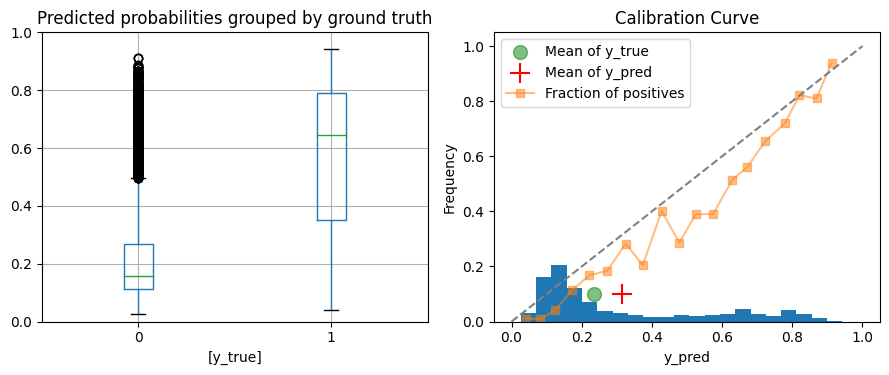

{'F1': 0.639,
 'Average_Precision': 0.672,
 'AUC': 0.863,
 'Accuracy': 0.823,
 'Balanced_Accuracy': 0.768}

In [31]:
Metrics.score(model, y_pred=y_pred.view(-1).detach().cpu().numpy(), name="WSVAE")

In [32]:
pd.DataFrame(Metrics.metrics).T

,F1,Average_Precision,AUC,Accuracy,Balanced_Accuracy
MV,0.218,0.522,0.724,0.788,0.559
flippers,0.558,0.652,0.839,0.816,0.704
WSVAE,0.639,0.672,0.863,0.823,0.768
